In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2023-10-17 14:33:07.969206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:33:09.472379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tempfile

In [3]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-10-17 14:33:11.839196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 14:33:11.876533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 14:33:11.876767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### 1. Initialising Dataset

In [5]:
DATASET_ROOT_DIR = "/media/abhishek/data/college/q11/data_science/Incidents-subset-20230213T155459Z-001/incidents-subset_2"
BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dir = os.path.join(DATASET_ROOT_DIR, 'trainset')
val_dir = os.path.join(DATASET_ROOT_DIR, 'valset')
test_dir = os.path.join(DATASET_ROOT_DIR, 'testset')

trainset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

valset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)
testset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

Found 4704 files belonging to 12 classes.
Found 1176 files belonging to 12 classes.


2023-10-17 14:33:12.224231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 14:33:12.224437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 14:33:12.224570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 4704 files belonging to 12 classes.


In [6]:
for i, b in trainset.take(4):
    print(i.shape)
    print(b.shape)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext] name: 

In [7]:
class_names = trainset.class_names
num_classes = len(class_names)
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in trainset.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

['airplane accident', 'bicycle accident', 'car accident', 'collapsed', 'earthquake', 'flooded', 'ice storm', 'nuclear explosion', 'oil spill', 'tornado', 'volcanic eruption', 'wildfire']


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext] name: 

<Figure size 1000x1000 with 0 Axes>

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

trainset = trainset.prefetch(buffer_size=AUTOTUNE)
trainset = trainset.ignore_errors(log_warning=True)
valset = valset.prefetch(buffer_size=AUTOTUNE)
testset = testset.prefetch(buffer_size=AUTOTUNE)

#### 1.1 Scale Image size to be appropriate for the model

### 2. Create base model from pretrained convnet

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
image_batch, label_batch = next(iter(trainset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-10-17 14:33:26.129972: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
2023-10-17 14:33:27.021664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


(32, 5, 5, 1280)


In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#### 2.1 Feature extraction
Freeze the conv layers

Add classification head


In [12]:
base_model.trainable = False

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
prediction_layer_1 = tf.keras.layers.Dense(128)
prediction_layer_2 = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer_2(prediction_layer_1(feature_batch_average))
print(prediction_batch.shape)

(32, 12)


In [15]:
inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer_2(prediction_layer_1(x))
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [18]:
# code from https://www.tensorflow.org/tutorials/images/classification

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 3. Train the model

In [19]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(valset)

 5/37 [===>..........................] - ETA: 1s - loss: 3.1586 - accuracy: 0.0812

2023-10-17 14:33:31.795564: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100687872 exceeds 10% of free system memory.


37/37 [==============================] - 8s 126ms/step - loss: 3.4360 - accuracy: 0.0876


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.44
initial accuracy: 0.09


In [21]:
history = model.fit(trainset,
                    epochs=initial_epochs,
                    validation_data=valset)

Epoch 1/10


2023-10-17 14:33:38.346304: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
2023-10-17 14:33:39.125483: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x82a5c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-17 14:33:39.125527: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro T1000 with Max-Q Design, Compute Capability 7.5
2023-10-17 14:33:39.187854: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-17 14:33:39.438994: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     20/Unknown - 5s 96ms/step - loss: 2.9145 - accuracy: 0.1766

2023-10-17 14:33:41.412241: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 87668625 exceeds 10% of free system memory.


     42/Unknown - 9s 126ms/step - loss: 2.5560 - accuracy: 0.2626

2023-10-17 14:33:44.841294: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


     58/Unknown - 10s 120ms/step - loss: 2.4028 - accuracy: 0.2953

2023-10-17 14:33:46.462338: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


     67/Unknown - 12s 130ms/step - loss: 2.3205 - accuracy: 0.3139

2023-10-17 14:33:48.240144: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


    146/Unknown - 20s 116ms/step - loss: 1.8244 - accuracy: 0.4427

2023-10-17 14:33:56.535451: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4047771796247001658
2023-10-17 14:33:56.535497: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2993210412694971074
2023-10-17 14:33:58.092491: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100687872 exceeds 10% of free system memory.


146/146 [==============================] - 25s 149ms/step - loss: 1.8244 - accuracy: 0.4427 - val_loss: 1.0438 - val_accuracy: 0.6582
Epoch 2/10


2023-10-17 14:34:01.595288: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 20/146 [===>..........................] - ETA: 13s - loss: 1.0582 - accuracy: 0.6641

2023-10-17 14:34:04.246862: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 87668625 exceeds 10% of free system memory.


 42/146 [=======>......................] - ETA: 13s - loss: 1.0359 - accuracy: 0.6592

2023-10-17 14:34:07.758137: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/146 [==========>...................] - ETA: 11s - loss: 1.0484 - accuracy: 0.6552

2023-10-17 14:34:09.471792: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 67/146 [============>.................] - ETA: 10s - loss: 1.0430 - accuracy: 0.6567

2023-10-17 14:34:11.237344: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - ETA: 0s - loss: 0.9804 - accuracy: 0.6779

2023-10-17 14:34:20.650996: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100687872 exceeds 10% of free system memory.


146/146 [==============================] - 23s 150ms/step - loss: 0.9804 - accuracy: 0.6779 - val_loss: 0.8034 - val_accuracy: 0.7398
Epoch 3/10


2023-10-17 14:34:24.391055: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 42/146 [=======>......................] - ETA: 13s - loss: 0.8226 - accuracy: 0.7344

2023-10-17 14:34:30.457956: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/146 [==========>...................] - ETA: 10s - loss: 0.8266 - accuracy: 0.7349

2023-10-17 14:34:32.154769: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 67/146 [============>.................] - ETA: 10s - loss: 0.8230 - accuracy: 0.7360

2023-10-17 14:34:33.904033: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 24s 155ms/step - loss: 0.7961 - accuracy: 0.7411 - val_loss: 0.7355 - val_accuracy: 0.7568
Epoch 4/10


2023-10-17 14:34:47.968924: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 42/146 [=======>......................] - ETA: 13s - loss: 0.6843 - accuracy: 0.7708

2023-10-17 14:34:53.913696: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/146 [==========>...................] - ETA: 10s - loss: 0.6986 - accuracy: 0.7619

2023-10-17 14:34:55.511728: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 67/146 [============>.................] - ETA: 10s - loss: 0.6969 - accuracy: 0.7668

2023-10-17 14:34:57.132969: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 21s 141ms/step - loss: 0.6778 - accuracy: 0.7721 - val_loss: 0.6701 - val_accuracy: 0.7772
Epoch 5/10


2023-10-17 14:35:09.376805: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 42/146 [=======>......................] - ETA: 12s - loss: 0.6479 - accuracy: 0.7894

2023-10-17 14:35:15.035602: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/146 [==========>...................] - ETA: 10s - loss: 0.6490 - accuracy: 0.7936

2023-10-17 14:35:16.692828: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 67/146 [============>.................] - ETA: 9s - loss: 0.6508 - accuracy: 0.7910 

2023-10-17 14:35:18.283112: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 22s 143ms/step - loss: 0.6196 - accuracy: 0.7980 - val_loss: 0.6601 - val_accuracy: 0.7772
Epoch 6/10


2023-10-17 14:35:30.990120: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 42/146 [=======>......................] - ETA: 13s - loss: 0.5942 - accuracy: 0.8103

2023-10-17 14:35:37.168697: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/146 [==========>...................] - ETA: 10s - loss: 0.5880 - accuracy: 0.8071

2023-10-17 14:35:38.815155: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 67/146 [============>.................] - ETA: 10s - loss: 0.5823 - accuracy: 0.8069

2023-10-17 14:35:40.564413: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 22s 146ms/step - loss: 0.5695 - accuracy: 0.8143 - val_loss: 0.6295 - val_accuracy: 0.7917
Epoch 7/10


2023-10-17 14:35:53.121805: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 42/146 [=======>......................] - ETA: 12s - loss: 0.5167 - accuracy: 0.8371

2023-10-17 14:35:58.871591: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/146 [==========>...................] - ETA: 10s - loss: 0.5323 - accuracy: 0.8319

2023-10-17 14:36:00.538671: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 67/146 [============>.................] - ETA: 10s - loss: 0.5235 - accuracy: 0.8321

2023-10-17 14:36:02.127297: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 21s 142ms/step - loss: 0.5234 - accuracy: 0.8295 - val_loss: 0.6201 - val_accuracy: 0.7891
Epoch 8/10


2023-10-17 14:36:14.565741: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 42/146 [=======>......................] - ETA: 12s - loss: 0.4971 - accuracy: 0.8400

2023-10-17 14:36:20.292854: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/146 [==========>...................] - ETA: 10s - loss: 0.5226 - accuracy: 0.8303

2023-10-17 14:36:21.871824: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 67/146 [============>.................] - ETA: 9s - loss: 0.5129 - accuracy: 0.8330 

2023-10-17 14:36:23.457613: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 21s 138ms/step - loss: 0.4959 - accuracy: 0.8383 - val_loss: 0.6083 - val_accuracy: 0.8002
Epoch 9/10


2023-10-17 14:36:35.419992: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 42/146 [=======>......................] - ETA: 12s - loss: 0.4587 - accuracy: 0.8482

2023-10-17 14:36:41.038686: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/146 [==========>...................] - ETA: 10s - loss: 0.4822 - accuracy: 0.8400

2023-10-17 14:36:42.606566: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 67/146 [============>.................] - ETA: 9s - loss: 0.4794 - accuracy: 0.8405

2023-10-17 14:36:44.210807: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 21s 139ms/step - loss: 0.4642 - accuracy: 0.8477 - val_loss: 0.6085 - val_accuracy: 0.7883
Epoch 10/10


2023-10-17 14:36:56.400169: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 42/146 [=======>......................] - ETA: 12s - loss: 0.4508 - accuracy: 0.8601

2023-10-17 14:37:02.070812: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/146 [==========>...................] - ETA: 10s - loss: 0.4651 - accuracy: 0.8534

2023-10-17 14:37:03.625001: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 67/146 [============>.................] - ETA: 9s - loss: 0.4643 - accuracy: 0.8549

2023-10-17 14:37:05.123580: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 20s 133ms/step - loss: 0.4443 - accuracy: 0.8578 - val_loss: 0.6099 - val_accuracy: 0.7959


In [24]:
model(trainset.take(1).get_single_element(0)[0])

2023-10-17 14:45:05.480194: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


<tf.Tensor: shape=(32, 12), dtype=float32, numpy=
array([[ 4.3583617e-01, -8.4134269e-01,  8.7881410e-01, -6.4252400e-01,
         8.5320193e-01,  8.2356234e+00,  8.3387899e-01, -1.4143689e+00,
         1.9371974e+00, -1.8734159e+00, -1.0492158e+00, -1.8471824e+00],
       [ 1.9269419e-01, -3.3816972e+00, -4.7955256e+00,  3.2738611e-01,
         2.3088143e+00, -2.8807130e+00, -4.1989565e+00,  4.2430830e+00,
        -2.8952491e+00,  1.4984794e-01,  1.7521982e+00,  7.8672714e+00],
       [ 2.0045826e+00, -3.2207816e+00,  5.9856290e-01,  8.8352299e+00,
         1.3631429e+01,  3.1955369e+00, -5.6733942e-01, -3.8134482e+00,
         1.3701799e+00, -1.1493840e+00, -5.3148198e+00, -2.6675111e-01],
       [ 8.4498243e+00,  1.7391202e+00,  2.5058105e+00,  5.5172119e+00,
         5.4050307e+00,  9.9836469e-01, -2.9379117e+00, -2.3327997e+00,
        -2.1826291e+00, -1.5415128e+00, -5.7889919e+00, -8.2623631e-01],
       [ 2.2704071e-01, -3.5546494e+00,  5.1446819e-01,  1.6695848e+00,
         7

In [26]:
trainset.take(1).get_single_element(0)[1]

2023-10-17 14:45:32.075107: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 5,  2,  2,  2,  2,  5,  2,  7,  5,  2, 11, 10,  2,  3,  0,  4,  5,
        6,  5,  3,  2,  8,  5, 11,  2, 10,  5, 10,  4,  0,  5,  2],
      dtype=int32)>

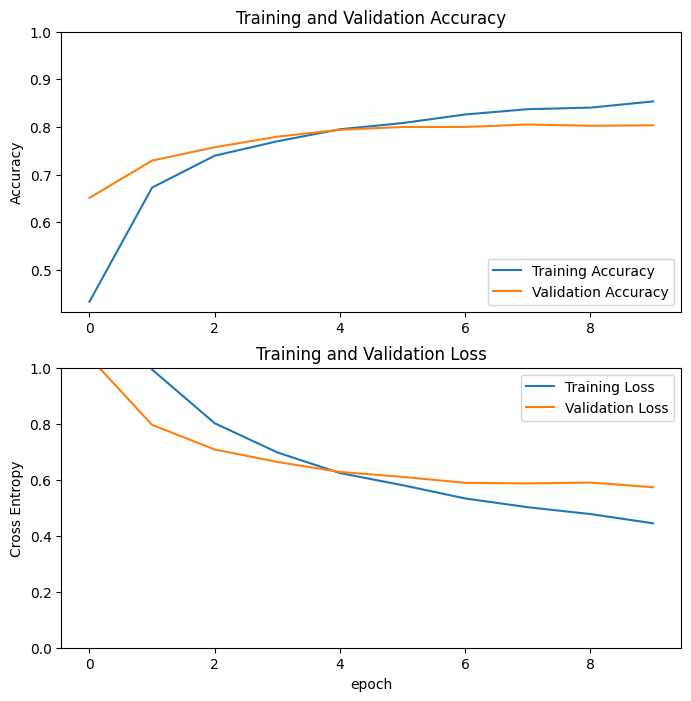

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:

model.save_weights("mobile_net_trained_incidents_1.h5", overwrite=True)

In [33]:
base_model_trained = model.layers[3]
base_model_trained = sparsity.prune_low_magnitude(base_model_trained)
base_model_trained.save_weights("mobile_net_trained_incidents_1.h5", overwrite=True)

In [ ]:
base_model_trained.summary()

In [23]:
#Understanding base model

conv_layers_full_size = {}

for layer in base_model.layers:
    
    if isinstance(layer, tf.keras.layers.Conv2D):
        # print(layer.name, end="\t")
        # print(layer.count_params())
        conv_layers_full_size[layer.name] = layer.count_params()
        # print(tf.math.count_nonzero(layer.trainable_weights, axis=None))

print()
print(conv_layers_full_size)
print(sum(conv_layers_full_size.values()))


{'Conv1': 864, 'expanded_conv_project': 512, 'block_1_expand': 1536, 'block_1_project': 2304, 'block_2_expand': 3456, 'block_2_project': 3456, 'block_3_expand': 3456, 'block_3_project': 4608, 'block_4_expand': 6144, 'block_4_project': 6144, 'block_5_expand': 6144, 'block_5_project': 6144, 'block_6_expand': 6144, 'block_6_project': 12288, 'block_7_expand': 24576, 'block_7_project': 24576, 'block_8_expand': 24576, 'block_8_project': 24576, 'block_9_expand': 24576, 'block_9_project': 24576, 'block_10_expand': 24576, 'block_10_project': 36864, 'block_11_expand': 55296, 'block_11_project': 55296, 'block_12_expand': 55296, 'block_12_project': 55296, 'block_13_expand': 55296, 'block_13_project': 92160, 'block_14_expand': 153600, 'block_14_project': 153600, 'block_15_expand': 153600, 'block_15_project': 153600, 'block_16_expand': 153600, 'block_16_project': 307200, 'Conv_1': 409600}
2125536


In [24]:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.0, begin_step=0,
         frequency=100
    )
}

pruning_params_t2 = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.81, begin_step=0,
         frequency=100
    )
}

In [32]:
conv_layers_pruned_size = {}


def clone_layers_mobilenet(layer_i):
    if isinstance(layer_i, tf.keras.layers.Conv2D):
        ret_layer = sparsity.prune_low_magnitude(layer_i, pruning_params_t2, name = layer_i.name)
        print(layer_i.name, "\t", ret_layer.name)
        # ret_layer.name = layer_i.name
        return ret_layer
    else:
        return layer_i


pruned_mobilenet = tf.keras.models.clone_model(base_model_trained, clone_function=clone_layers_mobilenet)
pruned_mobilenet.load_weights("mobile_net_trained_incidents_1.h5")
sparsity.strip_pruning(pruned_mobilenet)

# pruned_mobilenet.summary(expand_nested=True)

for layer in pruned_mobilenet.layers:
    print(type(layer))
    # try:
    #     print(tf.math.count_nonzero(layer.trainable_weights))
    # except:
    #     print("bl\n")
    
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name, end="\t")
        print(layer.count_params())
        # conv_layers_pruned_size[layer.name] = layer.count_params()
        print(tf.math.count_nonzero(layer.trainable_weights, axis=None))
        
        
        # print(tf.math.count_nonzero(layer.trainable_weights, axis=None))

print()
print(conv_layers_pruned_size)
print(sum(conv_layers_pruned_size.values()))

Conv1 	 prune_low_magnitude_Conv1
expanded_conv_project 	 prune_low_magnitude_expanded_conv_project
block_1_expand 	 prune_low_magnitude_block_1_expand
block_1_project 	 prune_low_magnitude_block_1_project
block_2_expand 	 prune_low_magnitude_block_2_expand
block_2_project 	 prune_low_magnitude_block_2_project
block_3_expand 	 prune_low_magnitude_block_3_expand
block_3_project 	 prune_low_magnitude_block_3_project
block_4_expand 	 prune_low_magnitude_block_4_expand
block_4_project 	 prune_low_magnitude_block_4_project
block_5_expand 	 prune_low_magnitude_block_5_expand
block_5_project 	 prune_low_magnitude_block_5_project
block_6_expand 	 prune_low_magnitude_block_6_expand
block_6_project 	 prune_low_magnitude_block_6_project
block_7_expand 	 prune_low_magnitude_block_7_expand
block_7_project 	 prune_low_magnitude_block_7_project
block_8_expand 	 prune_low_magnitude_block_8_expand
block_8_project 	 prune_low_magnitude_block_8_project
block_9_expand 	 prune_low_magnitude_block_9_expand


ValueError: Weight count mismatch for layer #0 (named prune_low_magnitude_Conv1 in the current model, Conv1 in the save file). Layer expects 4 weight(s). Received 1 saved weight(s)

In [54]:
pruning_curve = []
limit = 0.09
step_i_size = 1
while step_i_size > limit:
    pruning_curve.append(step_i_size)
    step_i_size *= 0.9
pruning_curve = np.asarray(pruning_curve)
np.round(pruning_curve, 3)
print("Percentage of non-zero weights in pruning steps:", pruning_curve)
print("number of pruning steps: ", pruning_curve.shape)

Percentage of non-zero weights in pruning steps: [1.         0.9        0.81       0.729      0.6561     0.59049
 0.531441   0.4782969  0.43046721 0.38742049 0.34867844 0.3138106
 0.28242954 0.25418658 0.22876792 0.20589113 0.18530202 0.16677182
 0.15009464 0.13508517 0.12157665 0.10941899 0.09847709]
number of pruning steps:  (23,)


In [48]:
conv_layers_pruning_steps = {}

i = 0
for k,v in conv_layers_full_size.items():
    
    i+=1
    if i > 17:
        print(list(conv_layers_full_size.keys())[i])
        original_size = v
        step_k_size = original_size
        while step_k_size > original_size / 1       

block_9_expand
block_9_project
block_10_expand
block_10_project
block_11_expand
block_11_project
block_12_expand
block_12_project
block_13_expand
block_13_project
block_14_expand
block_14_project
block_15_expand
block_15_project
block_16_expand
block_16_project
Conv_1


IndexError: list index out of range

In [53]:
pruning_curve = []
limit = 0.09
step_i_size = 1
while step_i_size > limit:
    pruning_curve.append(step_i_size)
    step_i_size *= 0.9
pruning_curve = np.asarray(pruning_curve)
np.round(pruning_curve, 3)
pruning_curve.shape

(23,)

In [44]:
len(conv_layers_full_size)

35

### 4. Fine tuning
Unfreeze the top layers

In [28]:
base_model.trainable = True


In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154
